sss 9.74, xgb 11.11

!pip install xgboost  #함수 install 다 추가할 것

In [40]:
import time
import re
import datetime as dt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import sin,cos,arccos,pi,round
import math
import warnings
warnings.filterwarnings('ignore')

In [53]:
df = pd.read_csv('대전풍향.csv', encoding = 'cp949',error_bad_lines=False)

In [54]:
sin_converter(df,'최대풍속풍향(deg)',360)
cos_converter(df,'최대풍속풍향(deg)',360)

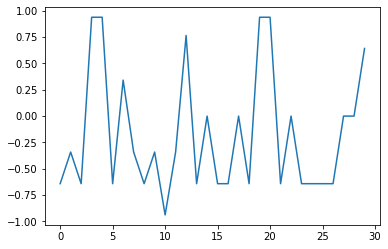

In [64]:
plt.plot(df['sin_최대풍속풍향(deg)'][:30])

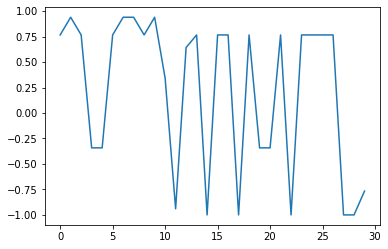

In [65]:

plt.plot(df['cos_최대풍속풍향(deg)'][:30])

In [2]:
loc_PM = pd.read_csv('./META/pmmap.csv', encoding = 'UTF-8',error_bad_lines=False)
loc_PM.head()

,Location,Latitude,Longitude,Description
0,아름동,36.512252,127.246789,세종특별자치시 보듬3로 114 아름동커뮤니티센터 옥상 (아름동)
1,신흥동,36.592887,127.292550,세종 조치원읍 군청로 87-16(신흥동) 세종특별자치시 조치원청사 옥상
2,노은동,36.368242,127.318498,대전 유성구 노은동로 87번길 89(노은1동 주민센터) 노은1동 주민센터 3층 옥상
3,문창동,36.317215,127.437825,대전 중구 보문로 20번길 38(문창동 주민센터) 문창동 주민센터
4,읍내동,36.372388,127.417714,대전 대덕구 대전로 1331번길 75(태아산업(주)) 태아산업(주)


In [3]:
loc_PM.sort_values(by=['Location'], ascending=True,inplace=True)
loc_PM.set_index('Location',inplace=True)

In [4]:
#Description Drop -> 스크린 공간을 너무 많이 잡아 먹어서 삭제 
loc_PM.drop('Description',axis = 1,inplace = True)

In [5]:
loc_PM.head()

,Latitude,Longitude
Location,,
공주,36.446951,127.119209
노은동,36.368242,127.318498
논산,36.199217,127.087021
대천2동,36.353148,126.589735
독곶리,36.987579,126.391672


In [6]:
loc_AWS = pd.read_csv('./META/awsmap.csv', index_col = 'Location', encoding = 'UTF-8',error_bad_lines=False)
loc_AWS.head()

,Latitude,Longitude,Description
Location,,,
오월드,36.2913,127.3959,대전광역시 중구사정공원로 70 오월드 내 플라워랜드
세천,36.3402,127.4938,대전광역시 동구세천동 63-1
장동,36.4135,127.4382,대전광역시 대덕구장동 360-2
세종고운,36.5315,127.2406,세종특별자치시 고운동산 25번지
세종금남,36.4585,127.2688,세종특별자치시 시군구금남면 성덕리 77-3


In [7]:
#Description Drop -> 스크린 공간을 너무 많이 잡아 먹어서 삭제 
loc_AWS.drop('Description',axis = 1,inplace = True)

In [8]:
loc_AWS.head()

,Latitude,Longitude
Location,,
오월드,36.2913,127.3959
세천,36.3402,127.4938
장동,36.4135,127.4382
세종고운,36.5315,127.2406
세종금남,36.4585,127.2688


In [9]:
# Train data import
PM_loc = []

for nm_PM in loc_PM.index:
    pm = pd.read_csv(f'./TRAIN/{nm_PM}.csv',encoding = 'UTF-8',error_bad_lines=False)
    PM_loc.append(pm)
    globals()['PM_{}'.format(nm_PM)] = pm
    
for nm_AWS in loc_AWS.index:
    globals()['AWS_{}'.format(nm_AWS)]=pd.read_csv(f'./TRAIN_AWS/{nm_AWS}.csv',encoding = 'UTF-8',error_bad_lines=False)

In [10]:
# Test data import
TPM_loc = []

for nm_PM in loc_PM.index:
    tpm = pd.read_csv(f'./TEST_INPUT/{nm_PM}.csv',encoding = 'UTF-8',error_bad_lines=False)
    TPM_loc.append(tpm)
    globals()['TPM_{}'.format(nm_PM)] = tpm
    
for nm_AWS in loc_AWS.index:
    globals()['TAWS_{}'.format(nm_AWS)]=pd.read_csv(f'./TEST_AWS/{nm_AWS}.csv',encoding = 'UTF-8',error_bad_lines=False)

In [11]:
AWS_공주

,연도,일시,지점,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%)
0,0,01-01 00:00,공주,0.173776,0.201944,0.023018,0.0,0.828
1,0,01-01 01:00,공주,0.176935,0.168611,0.030691,0.0,0.831
2,0,01-01 02:00,공주,0.180095,0.087222,0.033248,0.0,0.784
3,0,01-01 03:00,공주,0.178515,0.087222,0.025575,0.0,0.745
4,0,01-01 04:00,공주,0.164297,0.113889,0.020460,0.0,0.750
...,...,...,...,...,...,...,...,...
35059,3,12-31 19:00,공주,0.287520,0.765833,0.071611,0.0,0.577
35060,3,12-31 20:00,공주,0.281201,0.753056,0.063939,0.0,0.586
35061,3,12-31 21:00,공주,0.260664,0.000000,0.010230,0.0,0.674
35062,3,12-31 22:00,공주,0.262243,0.011944,0.020460,0.0,0.660


## 함수 정리

In [46]:
import math

def incenter(x_lst, y_lst):  # 내심
    p1_x = x_lst[0];p1_y = y_lst[0]
    p2_x = x_lst[1];p2_y = y_lst[1]
    p3_x = x_lst[2];p3_y = y_lst[2]
    l12 = math.sqrt((p1_x - p2_x)**2 + (p1_y - p2_y)**2)
    l13 = math.sqrt((p1_x - p3_x)**2 + (p1_y - p3_y)**2)
    l23 = math.sqrt((p2_x - p3_x)**2 + (p2_y - p3_y)**2)
    X = (l12*p3_x + l13*p2_x + l23*p1_x) / (l12 + l13 + l23)
    Y = (l12*p3_y + l13*p2_y + l23*p1_y) / (l12 + l13 + l23)
    return (X,Y)

def centroid(x_lst, y_lst):   # 무게중심
    n = len(x_lst)
    X = 0;Y = 0
    X = sum(x_lst);Y = sum(y_lst)
    X /= n;Y /= n
    return (X,Y)

## aws 와의 거리 계산 함수 -> 단순 유클리드 거리가 아니라 gps상의 거리를 이용

def rad2deg(radians):
    degrees = radians * 180 / pi
    return degrees

def deg2rad(degrees):
    radians = degrees * pi / 180
    return radians

def getDistanceBetweenPointsNew(latitude1, longitude1, latitude2, longitude2, unit = 'miles'):
    theta = longitude1 - longitude2
    dist = 60 * 1.1515 * rad2deg(
        arccos(
            (sin(deg2rad(latitude1)) * sin(deg2rad(latitude2))) + 
            (cos(deg2rad(latitude1)) * cos(deg2rad(latitude2)) * cos(deg2rad(theta)))
        )
    )
    if unit == 'miles':
        return round(dist, 2)
    if unit == 'kilometers':
        return round(dist * 1.609344, 3)
def distance(p1, p2):  #거리
    p1_x = p1[0];p1_y = p1[1]
    p2_x = p2[0];p2_y = p2[1]
    D = getDistanceBetweenPointsNew(p1_x, p1_y, p2_x,p2_y, unit = 'kilometers')
    return D


In [47]:
## 달 ,날짜, 시간 구분해주기 -> 전부 int 정수형으로 
def time_spliter(df):
    df['달']=df['일시'].str.split("-").apply(lambda x: x[0]).apply(lambda x: int(x))
    
    
    df['날짜'] = df['일시'].str.split("-").apply(lambda x: x[1]).str.split(" ").apply(lambda x: x[0]).str.split(":").apply(lambda x: x[0]).apply(lambda x: int(x))
    df['시간'] = df['일시'].str.split("-").apply(lambda x: x[1]).str.split(" ").apply(lambda x: x[1]).str.split(":").apply(lambda x: x[0]).apply(lambda x: int(x))
    
    # 변경
    df['연간일자'] = df['달'] * 30 + df['날짜'] - 30
    
    #df.drop('일시',axis = 1,inplace = True)



## 주기성을 반영하기 위해서 달과 시간을 삼각함수에 집어 넣기 
# 참조
# https://dacon.io/competitions/official/235985/codeshare/7042?page=1&dtype=recent 

def sin_converter(df,col,a): ## 시간 변환 
    df[f"sin_{col}"] = df[col].apply(lambda x: math.sin(2*math.pi*x/a))

def cos_converter(df,col,a):
    df[f"cos_{col}"] = df[col].apply(lambda x: math.cos(2*math.pi*x/a))

def total_converter(df):
    sin_converter(df,'연간일자',365)
    cos_converter(df,'연간일자',365)

    sin_converter(df,'시간',24)
    cos_converter(df,'시간',24)
    
    sin_converter(df,'풍향(deg)',1)
    cos_converter(df,'풍향(deg)',1)


In [15]:
AWS_공주['풍향(deg)']
sin_converter(AWS_공주,'풍향(deg)',1)
cos_converter(AWS_공주,'풍향(deg)',1)

,연도,일시,지점,기온(°C),풍향(deg),풍속(m/s),강수량(mm),습도(%),sin_풍향(deg),cos_풍향(deg)
0,0,01-01 00:00,공주,0.173776,0.201944,0.023018,0.0,0.828,0.954761,0.297375
1,0,01-01 01:00,공주,0.176935,0.168611,0.030691,0.0,0.831,0.872069,0.489382
2,0,01-01 02:00,공주,0.180095,0.087222,0.033248,0.0,0.784,0.521010,0.853551
3,0,01-01 03:00,공주,0.178515,0.087222,0.025575,0.0,0.745,0.521010,0.853551
4,0,01-01 04:00,공주,0.164297,0.113889,0.020460,0.0,0.750,0.656059,0.754710
...,...,...,...,...,...,...,...,...,...,...
35059,3,12-31 19:00,공주,0.287520,0.765833,0.071611,0.0,0.577,-0.995056,0.099320
35060,3,12-31 20:00,공주,0.281201,0.753056,0.063939,0.0,0.586,-0.999816,0.019197
35061,3,12-31 21:00,공주,0.260664,0.000000,0.010230,0.0,0.674,0.000000,1.000000
35062,3,12-31 22:00,공주,0.262243,0.011944,0.020460,0.0,0.660,0.074979,0.997185


In [39]:
plt.figure(figsize = (20,9))
#plt.plot(AWS_공주['cos_풍향(deg)'][6:24*100:24])
plt.plot(PM_공주[PM_공주['강수량(mm)'] != 0])

KeyError: '강수량(mm)'

<Figure size 1440x648 with 0 Axes>

In [ ]:
rads = []
Near_AWS = []
Count_AWS = []
lctn_AWS = {}
for i in range(len(loc_PM.index)): # 17개 PM 관측소
    lat_PM = loc_PM['Latitude'][i]
    lon_PM = loc_PM['Longitude'][i]
    
    lats_AWS = [];lons_AWS = []
    
    near_AWS = ''
    rad = 0
    count_AWS = 0
    
    while len(near_AWS) == 0:
        # 변경
        rad += 5     # 반경을 조금씩 넓혀가며
        
        for j in range(len(loc_AWS.index)):
            lat_AWS = loc_AWS['Latitude'][j]
            lon_AWS = loc_AWS['Longitude'][j]
            if distance((lat_AWS, lon_AWS), (lat_PM, lon_PM)) < rad:
                count_AWS += 1
                lats_AWS.append(lat_AWS);lons_AWS.append(lon_AWS);
                near_AWS += str('/') + loc_AWS.index[j]
    
    rads.append(rad)
    Near_AWS.append(near_AWS[1:])
    Count_AWS.append(count_AWS)
    lctn_AWS[f'{loc_PM.index[i]}'] = [lats_AWS,lons_AWS]
    
loc_PM['Rad'] = rads
loc_PM['Near_AWS'] = Near_AWS
loc_PM['Count_AWS'] = Count_AWS
loc_PM

In [ ]:
cent_lat = [];cent_lon=[];distance_PC = []   # 일단 무게중심, 위도경도만
for nm_PM in loc_PM.index:
    cent_point = centroid(lctn_AWS[nm_PM][0], lctn_AWS[nm_PM][1])
    distance_PC.append(distance(cent_point,(loc_PM.loc[nm_PM]['Latitude'],loc_PM.loc[nm_PM]['Longitude'])))
    cent_lat.append(cent_point[0]);cent_lon.append(cent_point[1])
    

loc_PM['Cent_lat'] = cent_lat
loc_PM['Cent_lon'] = cent_lon
loc_PM['PM-Cent_d'] = distance_PC  #뺄까말까

#변경 - 칼럼 추가
loc_PM['sub_lat'] = loc_PM['Latitude'] - loc_PM['Cent_lat']
loc_PM['sub_lon'] = loc_PM['Longitude'] - loc_PM['Cent_lon']

loc_PM

## Train Dataset 만들기(AWS 이용)

In [ ]:
df = pd.DataFrame()

In [ ]:
'''
PM_loc = [PM_공주,PM_노은동, PM_논산,PM_대천2동,PM_독곶리,PM_동문동,PM_모종동, PM_문창동,PM_성성동,PM_신방동, PM_신흥동,
    PM_아름동,PM_예산군, PM_읍내동,PM_이원면, PM_정림동, PM_홍성읍]
'''

for i,nm_PM in enumerate(loc_PM.index):
    temp = PM_loc[i]
    #변경
    temp[['Rad','Count_AWS','sub_lat','sub_lon','PM-Cent_d']] = loc_PM.loc[nm_PM][['Rad','Count_AWS','sub_lat','sub_lon','PM-Cent_d']]
    connectaws = PM_loc[i].iloc[:,:2]
    listaws = list(loc_PM.iloc[i,3].split('/'))
    connectaws['기온(°C)'] = 0
    connectaws['풍향(deg)'] = 0
    connectaws['풍속(m/s)'] = 0
    connectaws['강수량(mm)'] = 0
    connectaws['습도(%)'] = 0
    for loc in listaws:
        a = pd.read_csv(f'./TRAIN_AWS/{loc}.csv',sep = ',|\n',encoding = 'UTF-8',error_bad_lines=False)
        connectaws['기온(°C)'] += a['기온(°C)']
        connectaws['풍향(deg)'] += a['풍향(deg)']
        connectaws['풍속(m/s)'] += a['풍속(m/s)']
        connectaws['강수량(mm)'] += a['강수량(mm)']
        connectaws['습도(%)'] += a['습도(%)']
    connectaws['기온(°C)'] /= len(listaws)
    connectaws['풍향(deg)']/= len(listaws)
    connectaws['풍속(m/s)'] /= len(listaws)
    connectaws['강수량(mm)']/= len(listaws)
    connectaws['습도(%)'] /= len(listaws)
    v = pd.merge(temp,connectaws,how='right',on=['연도','일시'])
    df = pd.concat([df,v], axis=0)
df.head()    

In [ ]:
df.tail()

In [ ]:
df.info()

In [ ]:
time_spliter(df)

In [ ]:
total_converter(df)

In [ ]:
df

df.drop(['달','날짜','시간','연간일자','풍향(deg)'],axis=1, inplace=True)

In [ ]:
df.columns

In [ ]:
df = df[['연도','sin_연간일자', 'cos_연간일자', 'sin_시간', 'cos_시간', '측정소', 'Rad', 'Count_AWS', 'sub_lat', 'sub_lon',
       'PM-Cent_d', '기온(°C)', 'sin_풍향(deg)', 'cos_풍향(deg)' , '풍속(m/s)', '강수량(mm)', '습도(%)','PM2.5']]
df.head()

In [ ]:
loc = list(set(df['측정소']))
loc

In [ ]:
from sklearn.preprocessing import LabelEncoder
observations = loc
encoder = LabelEncoder()
encoder.fit(observations)
df['측정소'] = encoder.transform(df['측정소'])

In [ ]:
df.head()

## TEST 데이터 영역

In [ ]:
tdf = pd.DataFrame()

In [ ]:
'''
TPM_loc = [TPM_공주,TPM_노은동, TPM_논산,TPM_대천2동,TPM_독곶리,TPM_동문동,TPM_모종동, TPM_문창동,TPM_성성동,TPM_신방동, TPM_신흥동,
    TPM_아름동,TPM_예산군, TPM_읍내동,TPM_이원면, TPM_정림동, TPM_홍성읍]
'''
TPM_loc[0]

In [ ]:
for i,nm_PM in enumerate(loc_PM.index):
    temp = TPM_loc[i]
    temp[['Rad','Count_AWS','sub_lat','sub_lon','PM-Cent_d']] = loc_PM.loc[nm_PM][['Rad','Count_AWS','sub_lat','sub_lon','PM-Cent_d']]
    connectaws = TPM_loc[i].iloc[:,:2]
    listaws = list(loc_PM.iloc[i,3].split('/'))
    connectaws['기온(°C)'] = 0
    connectaws['풍향(deg)'] = 0
    connectaws['풍속(m/s)'] = 0
    connectaws['강수량(mm)'] = 0
    connectaws['습도(%)'] = 0
    err = 0
    for loc in listaws:
        a = pd.read_csv(f'./TEST_AWS/{loc}.csv',sep = ',|\n',encoding = 'UTF-8',error_bad_lines=False)
        a.fillna(method='ffill',inplace=True)
        connectaws['기온(°C)'] += a['기온(°C)']
        connectaws['풍향(deg)'] += a['풍향(deg)']
        connectaws['풍속(m/s)'] += a['풍속(m/s)']
        connectaws['강수량(mm)'] += a['강수량(mm)']
        connectaws['습도(%)'] += a['습도(%)']
    connectaws['기온(°C)'] /= (len(listaws))
    connectaws['풍향(deg)']/= len(listaws)
    connectaws['풍속(m/s)'] /= len(listaws)
    connectaws['강수량(mm)']/= len(listaws)
    connectaws['습도(%)'] /= len(listaws)
    v = pd.merge(temp,connectaws,how='right',on=['연도','일시'])
    tdf = pd.concat([tdf,v], axis=0)
tdf.head()    

In [ ]:
sample = tdf[tdf['PM2.5'].isnull()]
sample.head()

In [ ]:
time_spliter(tdf)

In [ ]:
total_converter(tdf)

tdf.drop(['달','날짜','시간'],axis=1, inplace=True)

tdf.columns

In [ ]:
tdf = tdf[['연도','sin_연간일자', 'cos_연간일자', 'sin_시간', 'cos_시간', '측정소', 'Rad', 'Count_AWS', 'sub_lat', 'sub_lon',
       'PM-Cent_d', '기온(°C)', 'sin_풍향(deg)', 'cos_풍향(deg)' , '풍속(m/s)', '강수량(mm)', '습도(%)','PM2.5']]
tdf.head()

In [ ]:
tdf['측정소'] = encoder.transform(tdf['측정소'])

In [ ]:
tdf.head()

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
x_train = df.iloc[:, :-1]
y_train = df.iloc[:, -1]

In [ ]:
write =tdf[tdf['PM2.5'].isnull()]
write.head()

In [ ]:
tdf.dropna(axis=0, inplace=True)

In [ ]:
x_test = tdf.iloc[:, :-1]
y_test = tdf.iloc[:, -1]

In [ ]:
x_test.describe()

## 간단한 선형 모델 이용

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression, Ridge, Lasso
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(x_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(x_train, y_train)
models = [lr_reg, ridge_reg, lasso_reg]
for i,model in enumerate(models):
    pred = model.predict(x_test)
    print('{}의 mae:'.format(i), mae(pred,y_test))

In [ ]:
result = write.iloc[:,:-1]

In [ ]:
result.fillna(method='ffill')

In [ ]:
ans = pd.read_csv('answer_sample.csv',error_bad_lines=False,sep = ',|\n|\t')

In [ ]:
print(len(ans.index))

In [ ]:
answer = ridge_reg.predict(result)

In [ ]:
result.describe()

In [ ]:
result.info()

In [ ]:
ans.head()

In [ ]:
ans['PM2.5']= answer

In [ ]:
ans.head()

In [ ]:
ans.info()

In [ ]:
ans.to_csv(path_or_buf='sss.csv', sep = ',', index = False)

## XGB 이용

In [ ]:
def evaluate_regr(y,pred):
    mae_val = mae(y,pred)
    print(f'MAE:{mae_val}')

In [ ]:
def get_model_predict(model,x_train,x_test,y_train,y_test,is_expm1=False):
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    evaluate_regr(y_test,pred)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor 
xgb_reg = XGBRegressor(n_estimators=500)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
get_model_predict(xgb_reg,x_train,x_test,y_train_log,y_test_log,is_expm1=True)

In [ ]:
log_answer= xgb_reg.predict(result)

In [ ]:
answer = np.expm1(log_answer)

In [ ]:
ans['PM2.5']= answer

In [ ]:
ans.head()

In [ ]:
ans.to_csv(path_or_buf='XGB.csv')